SEP 775 Final Project Code (Evaluation of AI Teaching Assistant)

Submitted By Group-4 :

Rutvik, Damjibhai Roy – 400490159

Meetkumar Patel - 400547066

Mridu - 400547058

Srey Patel - 400546143

In [1]:
# Install necessary packages

!pip install langchain==0.1.14
!pip install sentence-transformers==2.6.1
!pip install faiss-cpu==1.8.0
!pip install pdfminer.six==20231228
!pip install llama_cpp_python==0.2.58
!pip install tiktoken==0.6.0
!pip install gdown==5.1.0

# **1. Load Documents (PDF files of SEP 775 Course Material )**

In [ ]:
# Download llama-2 model from gdrive (do not need to download again if have already run implimentation code file)

import gdown

id='1fJPVfJssRO-PXaHKkxMe4BZ2PS4QwXBn'
url = f"https://drive.google.com/uc?id={id}"
output = "llama-2-7b-chat.Q4_K_M.gguf"
gdown.download(url, output)

In [4]:
# Download all pdf files from gdrive

import gdown

id="1SmvI9knJH6gKjeyNNnU9vcjFzsjOAYd7"

!mkdir '/content/All_lecture_pdfs'
output='/content/All_lecture_pdfs'

documents=gdown.download_folder(id=id,output=output, quiet=True)

The syntax of the command is incorrect.


# **2. Extract Text and Metadata**

In [5]:
# Define function to get last modified time
import os
import time

def get_modified_time(file):
  ti_m = os.path.getmtime(file)
  m_ti = time.ctime(ti_m)
  t_obj = time.strptime(m_ti)
  # Transforming the time object to a timestamp of ISO 8601 format
  T_stamp = time.strftime("%Y-%m-%d %H:%M:%S", t_obj)
  return T_stamp

def replace_newlines(text):
    # Replace newline and carriage return + line feed characters with spaces
    return text.replace('\n', ' ').replace('\r\n', ' ').replace('\x0c', ' ')

def fix_missing_spaces(text):
    # Split text into sentences
    sentences = text.split('. ')
    # Add space after period for each sentence
    fixed_text = '. '.join(sentence + (' ' if i < len(sentences) - 1 else '') for i, sentence in enumerate(sentences))
    return fixed_text

In [6]:
# Extract text from course materials

from pdfminer.high_level import extract_text, extract_pages
from pdfminer.layout import LTTextContainer
from pdfminer.pdfpage import PDFPage

def prepare_docs(pdf_docs):
    docs = []
    metadata = []
    content = []

    for pdf in pdf_docs:
      for page_number, page_layout in enumerate(extract_pages(pdf), start=1):
        # Extract text from the page layout
        text = ""
        for element in page_layout:
            if isinstance(element, LTTextContainer):
                text += element.get_text()

        text = replace_newlines(text)
        text = fix_missing_spaces(text)
        doc_page = {'title': pdf.split("/")[-1] + " page " + str(page_number),
                    'last_modified_time': get_modified_time(pdf),
                    'content': text,
                    'file_page': "empty_url"}
        docs.append(doc_page)

    for doc in docs:
        content.append(doc["content"])
        metadata.append({
            "title": doc["title"],
            "last_modified_time": doc["last_modified_time"],
            "file_page": doc["file_page"]
        })

    print("Content and metadata are extracted from the documents")

    return content, metadata

In [7]:
# split extracted text into chunks

from langchain.text_splitter import RecursiveCharacterTextSplitter

def get_text_chunks(content, metadata):

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=512,chunk_overlap=15)
    split_docs = text_splitter.create_documents(content, metadatas=metadata)
    print(f"Documents are split into {len(split_docs)} passages")

    return split_docs

# **3. Vector Database**

In [8]:
# vector database

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', model_kwargs={'device': 'cpu'})

def ingest_into_vectordb(split_docs):
    embeddings = embedding_model
    db = FAISS.from_documents(split_docs, embeddings)

    DB_FAISS_PATH = 'vectorstore/db_faiss'
    db.save_local(DB_FAISS_PATH)
    return db

In [9]:
content, metadata = prepare_docs(documents)

Content and metadata are extracted from the documents


In [10]:
split_docs = get_text_chunks(content, metadata)

Documents are split into 550 passages


In [11]:
vectordb=ingest_into_vectordb(split_docs)

# **4. Database Retriver**

In [12]:
# set retriver

retriever = vectordb.as_retriever(search_kwargs={"k": 3})

In [13]:
user_query="What is RNN?"
query_embedding = embedding_model.embed_query(user_query)
print(query_embedding)

[-0.12031888961791992, -0.0791710615158081, -0.045413099229335785, 0.03378608450293541, 0.008108887821435928, 0.05630357190966606, -0.010072465054690838, 0.022870983928442, 0.03511160984635353, -0.06259121745824814, -0.11304834485054016, 0.10516738891601562, -0.031245378777384758, 0.05396156758069992, -0.1244860589504242, -0.03206894174218178, -0.05337448790669441, 0.02014041505753994, 0.00602209335193038, 0.02387286350131035, -0.03664505109190941, 0.016491368412971497, 0.027449429035186768, 0.02671537548303604, 0.1028013676404953, -0.05205773562192917, 0.03360942751169205, 0.0037338477559387684, 0.0590813122689724, 0.01760351099073887, 0.10120707750320435, 0.0419500395655632, -0.015093906782567501, 0.059379689395427704, -0.05930512025952339, 0.03847121074795723, -0.06145157665014267, -0.007195510435849428, -0.00044852582504972816, 0.010541011579334736, 0.01921146549284458, -0.016691187396645546, -0.0007071052677929401, -0.04399329423904419, 0.1261902153491974, 0.01370253786444664, 0.0

In [14]:
# test retriver

docs = retriever.get_relevant_documents(user_query)

for i,doc in enumerate(docs):
  print(f"Retrived Chunk - {i+1} :",docs[i].page_content)
  print(" ")
  print("Title:",doc.metadata["title"])
  print("Last_modified_time:",doc.metadata["last_modified_time"])
  print("URL:",doc.metadata["file_page"])
  print("-"*40)
  print(" ")

Retrived Chunk - 1 : Other RNN Architectures
 
Title: All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 71
Last_modified_time: 2024-03-25 23:58:51
URL: empty_url
----------------------------------------
 
Retrived Chunk - 2 : Terminology The RNN described in this lecture = simple/vanilla/Elman RNN You learned about other RNN flavors like LSTM and GRU and multi-layer RNNs By the end of the course: You will understand phrases like “stacked bidirectional LSTMs with residual connections and self-attention” 83
 
Title: All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 83
Last_modified_time: 2024-03-25 23:58:51
URL: empty_url
----------------------------------------
 
Retrived Chunk - 3 : Other RNN uses: RNNs can be used for sequence tagging e.g., part-of-speech tagging, named entity recognition DT JJ NN VBN IN DT NN the startled cat knocked over the vase 72
 
Title: All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 72
Last_modified_time: 2024-03-25 23:58:51
URL: empty_url
------------------

In [15]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **5. RAG Conversational Chain**

In [16]:
from langchain_community.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

llama_llm = LlamaCpp(
model_path="llama-2-7b-chat.Q4_K_M.gguf",
n_gpu_layers=15000, # The number of layers to put on the GPU.
n_threads=6,     # Number of CPU core
n_batch=512,
temperature=0.8,
max_tokens=512,
top_p=0.95,
callback_manager=callback_manager,
n_ctx=4096,
verbose=True,
streaming=True)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from C:\Users\mridu1\Downloads\llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head

In [17]:
from langchain.prompts import PromptTemplate
from langchain.chains.question_answering import load_qa_chain

def get_conversational_chain():

    prompt_template ="""
    You are a helpful Teaching Assistant of the McMaster University and your name is 'Mac AI Assistant'\n
    You must answer the question based on context given below.\n
    Give answers in natural form, without giving context as of what you're doing internally.\n
    you must not mention that you are answering question based on the context in your asnwer
    If the question can not be answered using the information provided answer with I don't know, don't try to make up an answer.\n
    Use three sentences maximum. Keep the answer as concise as possible.\n
    If user question is more general for eaxmple 'Hi', 'Hi there!, 'Thanks', or 'How are you!', then asnwer them like a personal assistant of an user\n
    Always begin your answer with this dialog format:\n 'Mac AI Assistant: <your_Answer>' \n\n

    context:\n{context}\n

    User Question: \n{question}\n

    Answer: """

    prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])
    chain = load_qa_chain(llama_llm, chain_type="stuff", prompt=prompt)

    return chain


In [19]:
def user_input(user_question):
  docs = retriever.get_relevant_documents(user_question)
  chain = get_conversational_chain()
  response = chain.invoke({"input_documents": docs, "question": user_question})
  return response

In [23]:
import time
import nltk
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

# Load QA pairs from the CSV file
qa_pairs_csv = "QA_Pairs.csv"
qa_pairs = pd.read_csv(qa_pairs_csv, header=None)

bleu_score = []
time_taken = []

print(qa_pairs.head())

for row,qa_pair in qa_pairs.iterrows():
    user_query_ = qa_pair[0]
    print("User: ",user_query_)
    start_time = time.time()
    responce=user_input(user_query_)
    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60  # Convert to minutes

    print(" ")
    print("Citation:","Title -",responce['input_documents'][0].metadata["title"],"URL -", responce['input_documents'][0].metadata["file_page"])
    print("\n")
    print(f"Time taken to predict the answer: {execution_time_minutes:.2f} minutes")
    time_taken.append(f"{execution_time_minutes:.2f}")

    actual = responce['output_text']
    predicted = qa_pair[1]
    
    print("Predicted:", predicted)
    print("Actual:", actual)

    # Calculate BLEU score
    bleu_score.append(sentence_bleu([predicted], actual))
    print("BLEU Score for Reference:", bleu_score)

                                                   0  \
0         What is the primary objective of Word2Vec?   
1  What is the main advantage of representing wor...   
2  What is the purpose of the softmax function in...   
3  What is the primary goal of backpropagation in...   
4  What is the significance of language modeling ...   

                                                   1  
0  The primary objective of Word2Vec is to learn ...  
1  Representing words as dense vectors allows for...  
2  The softmax function is used to convert raw sc...  
3  The primary goal of backpropagation is to comp...  
4  Language modeling is crucial in NLP as it invo...  
User:  What is the primary objective of Word2Vec?


Llama.generate: prefix-match hit



Mac AI Assistant: Word2Vec's primary objective is to maximize predictive accuracy by minimizing the negative log likelihood of the data.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =       6.55 ms /    34 runs   (    0.19 ms per token,  5186.88 tokens per second)
llama_print_timings: prompt eval time =   16799.51 ms /   289 tokens (   58.13 ms per token,    17.20 tokens per second)
llama_print_timings:        eval time =    7773.25 ms /    33 runs   (  235.55 ms per token,     4.25 tokens per second)
llama_print_timings:       total time =   24804.06 ms /   322 tokens


 
Citation: Title - All_lecture_pdfs\lecture01-wordvecs1.pdf page 21 URL - empty_url


Time taken to predict the answer: 0.42 minutes
Predicted: The primary objective of Word2Vec is to learn word vectors by predicting context words given a center word in a large corpus of text.
Actual: 
Mac AI Assistant: Word2Vec's primary objective is to maximize predictive accuracy by minimizing the negative log likelihood of the data.
BLEU Score for Reference: [0.43021627748909924]
User:  What is the main advantage of representing words as dense vectors compared to one-hot vectors?


Llama.generate: prefix-match hit



Mac AI Assistant: Representing words as dense vectors allows for more accurate similarity measurements between words, as opposed to one-hot vectors where there is no natural notion of similarity. Dense vectors capture the nuances of word meaning in a more efficient way, enabling better matching of words with similar meanings. This can be particularly useful in natural language processing tasks such as text classification, language translation, and information retrieval.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      12.43 ms /    89 runs   (    0.14 ms per token,  7161.25 tokens per second)
llama_print_timings: prompt eval time =   26461.29 ms /   487 tokens (   54.34 ms per token,    18.40 tokens per second)
llama_print_timings:        eval time =   11150.13 ms /    88 runs   (  126.71 ms per token,     7.89 tokens per second)
llama_print_timings:       total time =   37991.66 ms /   575 tokens


 
Citation: Title - All_lecture_pdfs\lecture01-wordvecs1.pdf page 19 URL - empty_url


Time taken to predict the answer: 0.64 minutes
Predicted: Representing words as dense vectors allows for capturing semantic similarity between words, whereas one-hot vectors lack this capability.
Actual: 
Mac AI Assistant: Representing words as dense vectors allows for more accurate similarity measurements between words, as opposed to one-hot vectors where there is no natural notion of similarity. Dense vectors capture the nuances of word meaning in a more efficient way, enabling better matching of words with similar meanings. This can be particularly useful in natural language processing tasks such as text classification, language translation, and information retrieval.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344]
User:  What is the purpose of the softmax function in a neural network classifier?


Llama.generate: prefix-match hit



Mac AI Assistant: The softmax function is used to transform the output of a neural network into a probability distribution. It takes the output of the neuron and applies a mathematical operation to make it a probability distribution. This allows the classifier to assign probabilities to each class instead of assigning a fixed label to the input.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =       9.54 ms /    69 runs   (    0.14 ms per token,  7234.98 tokens per second)
llama_print_timings: prompt eval time =   19373.83 ms /   439 tokens (   44.13 ms per token,    22.66 tokens per second)
llama_print_timings:        eval time =    8462.71 ms /    68 runs   (  124.45 ms per token,     8.04 tokens per second)
llama_print_timings:       total time =   28111.75 ms /   507 tokens


 
Citation: Title - All_lecture_pdfs\lecture01-wordvecs1.pdf page 41 URL - empty_url


Time taken to predict the answer: 0.47 minutes
Predicted: The softmax function is used to convert raw scores or logits into probabilities, enabling the model to make predictions by assigning probabilities to different classes.
Actual: 
Mac AI Assistant: The softmax function is used to transform the output of a neural network into a probability distribution. It takes the output of the neuron and applies a mathematical operation to make it a probability distribution. This allows the classifier to assign probabilities to each class instead of assigning a fixed label to the input.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696]
User:  What is the primary goal of backpropagation in neural networks?


Llama.generate: prefix-match hit



Mac AI Assistant: The primary goal of backpropagation in neural networks is to efficiently compute gradients of the loss function with respect to the model's parameters. This allows the model to update its parameters in a way that minimizes the loss.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =       8.09 ms /    55 runs   (    0.15 ms per token,  6802.72 tokens per second)
llama_print_timings: prompt eval time =   17448.66 ms /   331 tokens (   52.71 ms per token,    18.97 tokens per second)
llama_print_timings:        eval time =    7047.60 ms /    54 runs   (  130.51 ms per token,     7.66 tokens per second)
llama_print_timings:       total time =   24740.60 ms /   385 tokens


 
Citation: Title - All_lecture_pdfs\lecture02-Neural Nets.pdf page 79 URL - empty_url


Time taken to predict the answer: 0.41 minutes
Predicted: The primary goal of backpropagation is to compute gradients of the loss function with respect to the model parameters, which are then used to update the parameters during training via optimization algorithms like gradient descent.
Actual: 
Mac AI Assistant: The primary goal of backpropagation in neural networks is to efficiently compute gradients of the loss function with respect to the model's parameters. This allows the model to update its parameters in a way that minimizes the loss.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696, 0.6552982638661834]
User:  What is the significance of language modeling in natural language processing?


Llama.generate: prefix-match hit



Mac AI Assistant: Language Modeling is a crucial component of many NLP tasks, including predictive text entry, speech recognition, handwriting recognition, spelling/grammar correction, authorship identification, machine translation, summarization, dialogue generation, and more! In fact, everything else in NLP has now been rebuilt upon Language Modeling - GPT-3 being a prime example! Language Modeling allows for the prediction of the next word in a sequence, given the previous words, with the goal of estimating the probability distribution of the entire sequence. In essence, it's like predicting the next word in a sentence or document!


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      18.57 ms /   139 runs   (    0.13 ms per token,  7484.79 tokens per second)
llama_print_timings: prompt eval time =   13339.44 ms /   293 tokens (   45.53 ms per token,    21.96 tokens per second)
llama_print_timings:        eval time =   16726.99 ms /   138 runs   (  121.21 ms per token,     8.25 tokens per second)
llama_print_timings:       total time =   30614.13 ms /   431 tokens


 
Citation: Title - All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 70 URL - empty_url


Time taken to predict the answer: 0.51 minutes
Predicted: Language modeling is crucial in NLP as it involves predicting the probability distribution of the next word in a sequence given the previous words, which forms the foundation for tasks like machine translation, speech recognition, and text generation.
Actual: 
Mac AI Assistant: Language Modeling is a crucial component of many NLP tasks, including predictive text entry, speech recognition, handwriting recognition, spelling/grammar correction, authorship identification, machine translation, summarization, dialogue generation, and more! In fact, everything else in NLP has now been rebuilt upon Language Modeling - GPT-3 being a prime example! Language Modeling allows for the prediction of the next word in a sequence, given the previous words, with the goal of estimating the probability distribution of the entire sequence. In essence, it's like

Llama.generate: prefix-match hit



Mac AI Assistant: Dropout is a regularization method used to prevent feature co-adaptation in neural networks. During training, randomly set a portion of input neurons to zero with a probability called the dropout ratio (usually around 0.5). During testing, multiply all weights by 1 minus the dropout ratio to prevent the model from relying too heavily on any one feature. This technique helps to improve model generalization by preventing features from becoming too specialized to a particular subset of data.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      16.43 ms /   110 runs   (    0.15 ms per token,  6695.48 tokens per second)
llama_print_timings: prompt eval time =   36320.30 ms /   720 tokens (   50.44 ms per token,    19.82 tokens per second)
llama_print_timings:        eval time =   14364.80 ms /   109 runs   (  131.79 ms per token,     7.59 tokens per second)
llama_print_timings:       total time =   51174.51 ms /   829 tokens


 
Citation: Title - All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 5 URL - empty_url


Time taken to predict the answer: 0.85 minutes
Predicted: Dropout regularization randomly sets a fraction of neuron inputs to zero during training to prevent overfitting and encourage robustness in deep learning models.
Actual: 
Mac AI Assistant: Dropout is a regularization method used to prevent feature co-adaptation in neural networks. During training, randomly set a portion of input neurons to zero with a probability called the dropout ratio (usually around 0.5). During testing, multiply all weights by 1 minus the dropout ratio to prevent the model from relying too heavily on any one feature. This technique helps to improve model generalization by preventing features from becoming too specialized to a particular subset of data.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696, 0.6552982638661834, 0.3412570951518617, 0.230047263296136]
User:  How does dropo

Llama.generate: prefix-match hit


 Mac AI Assistant: Dropout regularization during testing works by halving the model weights. This means that the model has fewer weights to use during testing, which can help prevent overfitting and improve generalization. When dropout is applied during testing, each neuron's weights are multiplied by a factor of 1 - p, where p is the dropout ratio. This has the effect of reducing the magnitude of the weights, making them less influential in the model's predictions. By using dropout during testing, we can prevent feature co-adaptation and improve the model's ability to generalize to new data.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      18.85 ms /   134 runs   (    0.14 ms per token,  7108.38 tokens per second)
llama_print_timings: prompt eval time =   32396.90 ms /   676 tokens (   47.92 ms per token,    20.87 tokens per second)
llama_print_timings:        eval time =   16406.07 ms /   133 runs   (  123.35 ms per token,     8.11 tokens per second)
llama_print_timings:       total time =   49340.21 ms /   809 tokens


 
Citation: Title - All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 5 URL - empty_url


Time taken to predict the answer: 0.82 minutes
Predicted: During testing, dropout is not applied, but instead, the model's weights are scaled by a factor equal to the dropout probability used during training.
Actual:  Mac AI Assistant: Dropout regularization during testing works by halving the model weights. This means that the model has fewer weights to use during testing, which can help prevent overfitting and improve generalization. When dropout is applied during testing, each neuron's weights are multiplied by a factor of 1 - p, where p is the dropout ratio. This has the effect of reducing the magnitude of the weights, making them less influential in the model's predictions. By using dropout during testing, we can prevent feature co-adaptation and improve the model's ability to generalize to new data.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696, 0.65

Llama.generate: prefix-match hit




Mac AI Assistant: Dropout regularization aims to address feature co-adaptation, which occurs when features adapt to each other during training, rather than learning generalizable patterns across all features. This can lead to overfitting, especially with deep neural networks. By randomly setting a fraction of inputs to zero during training, dropout regularization prevents features from adapting to each other too strongly, resulting in more generalizable models.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      14.70 ms /    93 runs   (    0.16 ms per token,  6327.82 tokens per second)
llama_print_timings: prompt eval time =   18737.69 ms /   381 tokens (   49.18 ms per token,    20.33 tokens per second)
llama_print_timings:        eval time =   12297.69 ms /    92 runs   (  133.67 ms per token,     7.48 tokens per second)
llama_print_timings:       total time =   31423.89 ms /   473 tokens


 
Citation: Title - All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 5 URL - empty_url


Time taken to predict the answer: 0.52 minutes
Predicted: Dropout regularization helps prevent feature co-adaptation, where features become overly dependent on each other, by randomly disabling neurons during training.
Actual: 

Mac AI Assistant: Dropout regularization aims to address feature co-adaptation, which occurs when features adapt to each other during training, rather than learning generalizable patterns across all features. This can lead to overfitting, especially with deep neural networks. By randomly setting a fraction of inputs to zero during training, dropout regularization prevents features from adapting to each other too strongly, resulting in more generalizable models.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696, 0.6552982638661834, 0.3412570951518617, 0.230047263296136, 0.1918517855637565, 0.26238441634908055]
User:  How does dropout re

Llama.generate: prefix-match hit



Mac AI Assistant: Dropout regularization helps prevent feature co-adaptation by randomly setting a portion of inputs to 0 during training, effectively creating an ensemble of different sub-networks. This makes the model less reliant on any single feature and better at generalizing to new data. By preventing feature co-adaptation, dropout regularization improves the model's ability to handle complex data and prevent overfitting.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      14.53 ms /    95 runs   (    0.15 ms per token,  6540.00 tokens per second)
llama_print_timings: prompt eval time =   20200.05 ms /   432 tokens (   46.76 ms per token,    21.39 tokens per second)
llama_print_timings:        eval time =   12374.71 ms /    94 runs   (  131.65 ms per token,     7.60 tokens per second)
llama_print_timings:       total time =   32961.84 ms /   526 tokens


 
Citation: Title - All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 4 URL - empty_url


Time taken to predict the answer: 0.55 minutes
Predicted: Dropout prevents feature co-adaptation by randomly dropping a certain percentage of inputs to each neuron during training, forcing the network to learn more robust features.
Actual: 
Mac AI Assistant: Dropout regularization helps prevent feature co-adaptation by randomly setting a portion of inputs to 0 during training, effectively creating an ensemble of different sub-networks. This makes the model less reliant on any single feature and better at generalizing to new data. By preventing feature co-adaptation, dropout regularization improves the model's ability to handle complex data and prevent overfitting.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696, 0.6552982638661834, 0.3412570951518617, 0.230047263296136, 0.1918517855637565, 0.26238441634908055, 0.290756778116221]
User:  What are the advantage

Llama.generate: prefix-match hit



Mac AI Assistant: Matrix multiplication is computationally more efficient than for loops when dealing with large datasets in neural networks. Using matrices allows for faster computation and reduces the risk of overfitting due to excessive computational power. Additionally, matrices can be easily manipulated using matrix operations such as transposition, dot product, and matrix multiplication, making it easier to implement neural network architectures.


llama_print_timings:        load time =   29558.55 ms
llama_print_timings:      sample time =      12.14 ms /    81 runs   (    0.15 ms per token,  6672.71 tokens per second)
llama_print_timings: prompt eval time =   19370.32 ms /   406 tokens (   47.71 ms per token,    20.96 tokens per second)
llama_print_timings:        eval time =    9801.33 ms /    80 runs   (  122.52 ms per token,     8.16 tokens per second)
llama_print_timings:       total time =   29471.80 ms /   486 tokens


 
Citation: Title - All_lecture_pdfs\lecture03-RNNs and LLMs.pdf page 7 URL - empty_url


Time taken to predict the answer: 0.49 minutes
Predicted: Matrices offer significant speed gains over for loops, especially when using GPUs, making them preferable for operations like multiplying softmax weights or processing large datasets efficiently.
Actual: 
Mac AI Assistant: Matrix multiplication is computationally more efficient than for loops when dealing with large datasets in neural networks. Using matrices allows for faster computation and reduces the risk of overfitting due to excessive computational power. Additionally, matrices can be easily manipulated using matrix operations such as transposition, dot product, and matrix multiplication, making it easier to implement neural network architectures.
BLEU Score for Reference: [0.43021627748909924, 0.2451780168785344, 0.32180848401311696, 0.6552982638661834, 0.3412570951518617, 0.230047263296136, 0.1918517855637565, 0.26238441634908055, 0

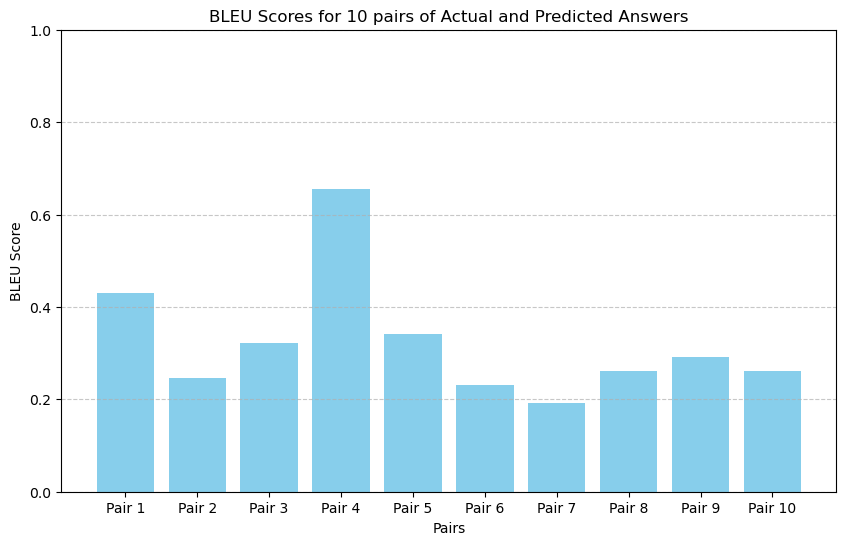

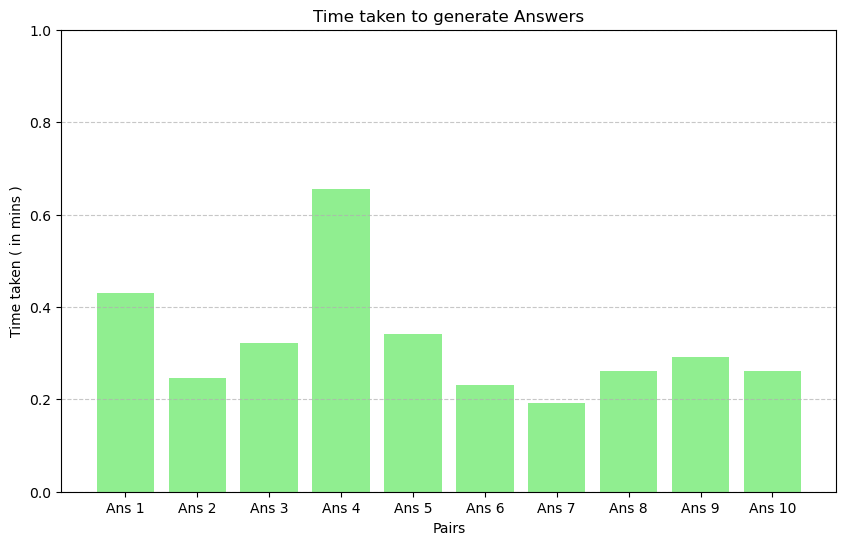

In [27]:
import matplotlib.pyplot as plt

pairs = [f"Pair {i+1}" for i in range(10)]

plt.figure(figsize=(10, 6))
plt.bar(pairs, bleu_score, color='skyblue')
plt.xlabel('Pairs')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for 10 pairs of Actual and Predicted Answers')
plt.ylim(0, 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

ans = [f"Ans {i+1}" for i in range(10)]

plt.figure(figsize=(10, 6))
plt.bar(ans, bleu_score, color='lightgreen')
plt.xlabel('Pairs')
plt.ylabel('Time taken ( in mins )')
plt.title('Time taken to generate Answers')
plt.ylim(0, 1) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()